# BICIMAD SPARK
Alejandro Leal Castaño \
Chenjie Huang \
Sara Antón Fernández

## Motivación
A partir de los datos de BICIMAD del mes de julio de 2017 y utilizando spark vamos a analizar:
- La lista de viajes en los que se sale y llega al mismo sitio (estación)
- El tiempo medio de viaje y la media de la duración por viaje individual.
- Uso medio de los usuarios. Media de todos uso por identificación.
- Cuales son los viajes más largos y más cortos.
- Las estaciones más concurridas.
- Estudio de los usos por cada día por medio de una gráfica.
- Estudio de los usos según la edad por medio de una gráfica.

In [6]:
from pyspark import SparkContext
import json

sc = SparkContext()

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*]) created by __init__ at /tmp/ipykernel_2880/3682140261.py:4 

In [ ]:
#sc.stop()

In [7]:
# RDD base y extraccion de datos

text_sample = '201707_movements.json'

rdd_base = sc.textFile(text_sample)

def mapper(line):
    data = json.loads(line)
    # u_t = data['user_type'] # No se necesita por ahora (?)
    u_c = data['user_day_code']
    start = data['idunplug_station']
    end = data['idplug_station']
    time = data['travel_time']
    date = data['unplug_hourTime']
    u_a = data['ageRange']
    return u_c, start, end, time, date, u_a

rdd = rdd_base.map(mapper)
rdd.count()

351289

In [4]:
print(rdd.take(10))

[('09a2f5ddbd53f1c6c529fdf1e3d60fc77001b5d41bd21806e09d40d8ae80fb33', 13, 61, 239, {'$date': '2017-07-01T01:00:00.000+0200'}, 4), ('f26e11fcb5aba6bfc136af58a61cb962c7e8cef0e593c8910bcb9883a4f38f14', 31, 44, 284, {'$date': '2017-07-01T01:00:00.000+0200'}, 4), ('86ef0681c2017e7c95986f5be1490c7027c9608fd29acc8967dcd6c33030361d', 14, 13, 109, {'$date': '2017-07-01T01:00:00.000+0200'}, 4), ('d46189d811469cad39c5f227847d7bfcfe7e27aac0777cd3b7b0f0f7245e42e8', 127, 89, 338, {'$date': '2017-07-01T01:00:00.000+0200'}, 4), ('739b535771ba572318e3f7a761eaa57ad1be934156bd228a6c1fa702068518c6', 85, 69, 333, {'$date': '2017-07-01T01:00:00.000+0200'}, 0), ('529a25e25e2ad97e5d6eec918d63dc340f36ed1881c68fb599b16657aa0dc604', 101, 107, 70, {'$date': '2017-07-01T01:00:00.000+0200'}, 4), ('058a5fd335215c4fb560c19d5bfe464557d4b63a2f212fdc05313c937d11a185', 38, 175, 222, {'$date': '2017-07-01T01:00:00.000+0200'}, 4), ('5b94380a0a97064949882478239f17737edcac8d1f8c91a6c85959b54d6ea0e6', 26, 13, 239, {'$date': '

## Análisis 1

Lista de viajes en la que se sale y llega al mismo sitio.
Salen y vuelven a la misma estación.

**Problema**: Ver personas que lo usan con el proposito de dar un paseo

*Datos necesarios*:
- 'user_day_code'
- 'id(un)plug_station'

In [8]:
# Filtrar cogiendo solo los que cumplan que "start = end"
rdd_ciclos = rdd.filter(lambda x: x[1] == x[2])

In [9]:
rdd_ciclos.count()

22085

In [10]:
rdd_ciclos.collect()

ERROR:root:KeyboardInterrupt while sending command.               (18 + 2) / 25]
Traceback (most recent call last):
  File "/home/sara/.local/lib/python3.8/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/sara/.local/lib/python3.8/site-packages/py4j/clientserver.py", line 475, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

## Análisis 2

Tiempo medio de viaje.
  Media de la duración por viaje individual.

Uso medio de los usuarios.
  Media de todos uso por identificación.

*Datos necesarios*:
- 'user_day_code'
- 'id(un)plug_station'
- 'travel_time'

Mas ideas:
- Ranking de viajes mas largos y mas cortos en tiempo.
- Mediana y otras medidas estadisticas (?)

### Tiempo medio por viaje

In [ ]:
rdd_travelTime = rdd.map(lambda x: x[3])

total_travels = rdd_travelTime.count()
total_travelTime = rdd_travelTime.sum()
average_travelTime = total_travelTime/total_travels

print(f'viajes: {total_travels}')
print(f'tiempo: {total_travelTime}')
print(f'media por viaje: {average_travelTime} segundos')

### Tiempo medio por identificador (persona)

In [ ]:
rdd_travelTime_id = rdd.map(lambda x: (x[0], x[3]))\
                        .groupByKey()\
                        .mapValues(sum)\
                        .map(lambda x: x[1])

total_travels_id = rdd_travelTime_id.count()
total_travelTime_id = rdd_travelTime_id.sum()
average_travelTime_id = total_travelTime_id/total_travels_id

print(f'viajes por id: {total_travels_id}')
print(f'tiempo: {total_travelTime_id}')
print(f'media por viaje: {average_travelTime_id} segundos/persona')

## Análisis 5
Gráfica con usos por cada día. \
\
Datos necesarios: fecha. \
\
Procedimiento:
- Hacer un map con un lambda para crear una tupla con los días como primer argumento
- Hacer un countByKey para tener como segundo argumento de las tuplas la cantidad de viajes que se hacen por día
Así tenemos un diccionario donde las key son los días y los value son la cantidad de viajes

In [16]:
dict_day = rdd.map(lambda x: (x[4]['$date'][8:10], _)).countByKey()


In [85]:
test = rdd.take(1)  # Se puede borrar pero no lo hago, solo lo digo
print(test[0][4]['$date'][8:10])

01


In [87]:
print(dict_day)

defaultdict(<class 'int'>, {'01': 8856, '02': 8420, '03': 12873, '04': 14057, '05': 14347, '06': 6925, '07': 8548, '08': 8695, '09': 9058, '10': 13155, '11': 13739, '12': 14113, '13': 13396, '14': 12415, '15': 8520, '16': 8264, '17': 12507, '18': 13183, '19': 13469, '20': 13688, '21': 12876, '22': 8856, '23': 7899, '24': 12380, '25': 13173, '26': 13395, '27': 13991, '28': 12581, '29': 8543, '30': 7788, '31': 11579})


Importamos la librería matplotlib.pyplot. Ponemos los días en el eje x, y la cantidad de viajes en el eje y.

In [18]:
import matplotlib.pyplot as plt

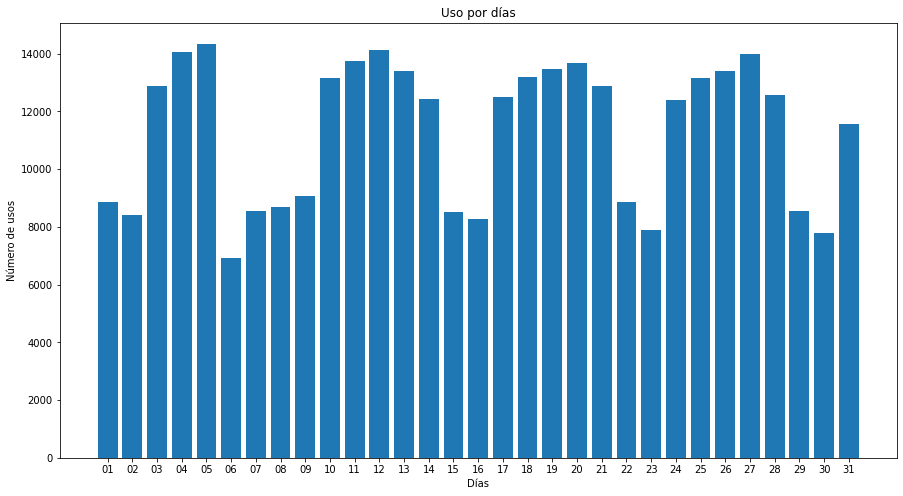

In [19]:
days = dict_day.keys()
num_usage = dict_day.values()

plt.figure(figsize=(15,8))
plt.bar(days, num_usage)
plt.ylabel('Número de usos')
plt.xlabel('Días')
plt.title('Uso por días')


plt.show()

## Análisis 6
Gráfica con usos por edades. \
\
Datos necesarios: tramos de edades. \
\
Procedimiento:
- Hacer un map con un lambda para crear una tupla con los días como primer argumento
- Hacer un groupByKey para agrupar los viajes por las edades de los usuarios y hacemos un mapValues(sum) para sumar los viajes
- Por último, nos quedamos con los valores, que son los viajes por los rangos de edad ordenados de los usuarios más jóvenes a los más mayores, estando primero el tramo de edades desconocidas.

In [20]:
rdd_age = rdd.map(lambda x: (x[5], 1)).groupByKey().sortByKey().mapValues(sum).values()

print(rdd_age.collect())


[69120, 8434, 5205, 37014, 158278, 71593, 1645]


In [22]:
#age_dic = {0:'unknown', 1:'0-16', 2:'17-18', 3:'19-26', 4:'27-40', 5:'41-65', 6:'66+'}
tuplas_age = rdd_age.collect()

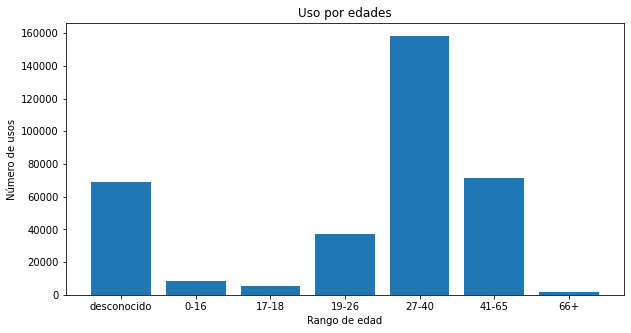

In [25]:
age = ['desconocido','0-16','17-18','19-26','27-40', '41-65','66+']
num_usage = tuplas_age

plt.figure(figsize=(10,5))
plt.bar(age, num_usage)
plt.ylabel('Número de usos')
plt.xlabel('Rango de edad')
plt.title('Uso por edades')


plt.show()
